In [1]:
#external stuff
import h5py
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
import cv2
import numpy as np
import math
import mahotas
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
import traceback

from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

In [2]:
#internal stuff
from contour_impl import do_contour_create, do_contour_compare
from imageprocessing import gray, image_preprocess, canny, grayto3

In [3]:
image_set_name = "icon1k"
logdir = "Logs20210918"

hdf5_file = h5py.File('LLD-icon.hdf5', 'r')
images, _ = (hdf5_file['data'], hdf5_file['labels/resnet/rc_64'])

# transpose the images because they're stored in a weird color channel first format, as indicated by shape[0] being 3
images = [np.transpose(i,(1,2,0)) if i.shape[0] == 3 else i for i in images[:100]]
print(len(images))
print("Loading Completed")

100
Loading Completed


In [144]:
def log(kwargs,message):
    if 'log' in kwargs:
        if 'info' in kwargs:
            message['info']=kwargs['info']
        if 'type' in message and message['type']=='Error':
            message['traceback']=traceback.format_exc()
        kwargs['log'] += [message]

timm_names=['cspdarknet53',
            'tf_efficientnetv2_l',
            'resnet50',
            'ecaresnetlight',
            'mixnet_s',
            'res2next50',
            'vit_small_r26_s32_224',
            'wide_resnet50_2']
def make_timm_method(modelname=timm_names[0], cuda=False):
    model = timm.create_model(modelname,pretrained=True,num_classes=0)
    if cuda:
        model = model.cuda()
    config = resolve_data_config({},model=model)
    transform = create_transform(**config)
    topil=transforms.ToPILImage()
    def create(img,**kwargs):
        try:
            timg=topil(img)
            timg=transform(timg).unsqueeze(0)
            if cuda:
                timg=timg.cuda()
            return model(timg).squeeze().detach().numpy()
        except:
            log(kwargs,{'type':'Error', 'method':'Timm_'+modelname, 'fn':'create'})
            return None
    def compare(v1,v2,**kwargs):
        try:
            return np.dot(v1,v2)
        except:
            log(kwargs,{'type':'Error', 'method':'Timm_'+modelname, 'fn':'compare'})
    return 'Timm_'+modelname, create,compare
        
# neural and small neural work on color images
def make_neural_method():
    # Load the pretrained model
    model = models.resnet18(pretrained=True)
    #strip the final layer to get a feature vector
    model = nn.Sequential(*list(model.children())[:-1])  
    # Set model to evaluation mode
    model.eval()

    def create(img,**kwargs):
        try:
            img=grayto3(img)
            scaler = transforms.Resize((224, 224))
            normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225])
            to_tensor = transforms.ToTensor()
            pillize = transforms.ToPILImage()
            loader = transforms.Compose([pillize, scaler, to_tensor, normalize])
            l_img = loader(img)
            t_img = Variable(l_img).unsqueeze(0)
            f_vec = model(t_img).squeeze()
            n_vec = f_vec.detach().numpy()
            n_vec = n_vec / np.linalg.norm(n_vec)
            return n_vec
        except:
            log(kwargs,{'type':'Error', 'method':'Neural', 'fn':'create'})
            return None

    def compare(v1, v2,**kwargs):
        try:
            return np.dot(v1, v2)
        except:
            log(kwargs,{'type':'Error', 'method':'Neural', 'fn':'compare'})
            return None   
    return "Neural", create, compare

def make_small_neural_method():
    class IconEmbeddingNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.convnet = nn.Sequential(
                nn.Conv2d(3, 32, 5),
                nn.PReLU(),
                nn.MaxPool2d(2, stride=2),
                nn.Conv2d(32, 64, 5),
                nn.PReLU(),
                nn.MaxPool2d(2, stride=2))
            self.fc = nn.Sequential(
                nn.Linear(64 * 4 * 4, 256),
                nn.PReLU(),
                nn.Linear(256, 256),
                nn.PReLU(),
                nn.Linear(256, 8)
                )
        def forward(self, x):
            output = self.convnet(x)
            output = output.view(output.size()[0], -1)
            output = self.fc(output)
            return output

        def get_embedding(self, x):
            return self.forward(x)
        
    model = IconEmbeddingNet()
    model.load_state_dict(torch.load("models/IconEmbeddingNet.pt"))
    model.eval()
    
    def create(img,**kwargs):
        try:
            img=grayto3(img)
            scaler = transforms.Resize((28, 28))
            normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225])
            to_tensor = transforms.ToTensor()
            pillize = transforms.ToPILImage()
            loader = transforms.Compose([pillize, scaler, to_tensor, normalize])
            l_img = loader(img)
            t_img = Variable(l_img).unsqueeze(0)
            f_vec = model(t_img).squeeze()
            n_vec = f_vec.detach().numpy()
            return n_vec
        except:
            log(kwargs,{'type':'Error', 'method':'Small_Neural', 'fn':'create'})
            return None

    def compare(v1, v2,**kwargs):
        try:
            sim = 100.0/(np.linalg.norm(v1-v2)+1)
            return sim
        except:
            log(kwargs,{'type':'Error', 'method':'Small_Neural', 'fn':'compare'})
            return None
    
    return "Small_Neural", create, compare


def make_orb_method():
    orb = cv2.ORB_create()
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    def create(img, **kwargs):
        try:
            img = gray(img)
            img = cv2.resize(img,None, fx=13, fy=13, interpolation=cv2.INTER_AREA)

            # find the keypoints and descriptors with orb
            kp1, des1 = orb.detectAndCompute(img,None)
            if len(kp1) < 2:
                des1 = None
            return des1
        except:
            log(kwargs,{'type':'Error', 'method':'Orb', 'fn':'create'})
            return None

    def compare(img_kp1, img_kp2, **kwargs):
        try:
            matches = matcher.match(img_kp1,img_kp2)
            score = len(matches)
            return score
        except:
            log(kwargs,{'type':'Error', 'method':'Orb', 'fn':'compare'})
            return 0
    return "Orb",create,compare

def make_zernike_method():
    # image preprocessing
    def zcenter(img):
        _, _, min_x, min_y, max_x, max_y, edges1 = image_preprocess(img) 
        edges2 = edges1[min_y:max_y+1, min_x:max_x+1]
        edges2 = cv2.resize(edges2, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
        return edges2
    def create(img, **kwargs):
        try:
            #zcenter is the image preprocessing code that was here before,
            #but zernike_moments is the real functional part of the method
            edges2=zcenter(img)
            zernike = mahotas.features.zernike_moments(edges2, 16)  
            return normalize(zernike[:,np.newaxis], axis=0).ravel()
        except:
            log(kwargs,{'type':'Error', 'method':'Zernike', 'fn':'create'})
            return None

    def compare(x,y, **kwargs):
        try:
            return np.dot(x,y)
        except:
            log(kwargs,{'type':'Error', 'method':'Zernike', 'fn':'compare'})
            return 0
    return "Zernike",create,compare

def make_contour_method(fractions=[.05,.1,.15,.2,.25,.3,.35,.4,.45,.5,.55,.6,.65,.7,.75,.8,.85,.9,.95]):
    def create(img, **kwargs):
        try:
            return do_contour_create(img,fractions,**kwargs)
        except:
            log(kwargs,{'type':'Error', 'method':'Contour', 'fn':'create'})
            return None
        
    def compare(query1, query2, error=0.1, **kwargs):
        try:
            return do_contour_compare(query1, query2, fractions,error,**kwargs)
        except:
            log(kwargs,{'type':'Error', 'method':'Contour', 'fn':'compare'})
            return 0
    
    return "Contour", create, compare

our_methods=[make_neural_method, make_small_neural_method, make_zernike_method, make_orb_method, make_contour_method]

In [156]:
def create_database(method,images,name):
    return [i for i in method] + [name] + [{i: method[1](images[i]) for i in range(len(images))}]
def run_query(database,img,candidates=None):
    imdesc = database[1](img)
    candidates = candidates or database[-1].keys()
    return [(i, database[2](imdesc,database[-1][i])) for i in candidates]
def test_database(database, images, )

In [157]:
m=make_timm_method()
db=create_database(m,images,'i100')

In [160]:
run_query(db,images[0])

[(0, 25.45041),
 (1, 17.117708),
 (2, 17.587751),
 (3, 15.234795),
 (4, 18.130966),
 (5, 17.313568),
 (6, 15.449609),
 (7, 14.88723),
 (8, 17.679392),
 (9, 18.414347),
 (10, 15.803551),
 (11, 15.424534),
 (12, 17.877222),
 (13, 16.687971),
 (14, 17.01299),
 (15, 18.051025),
 (16, 16.203552),
 (17, 13.869317),
 (18, 17.15984),
 (19, 15.604008),
 (20, 15.900633),
 (21, 16.142618),
 (22, 15.874975),
 (23, 18.431273),
 (24, 14.977854),
 (25, 15.699974),
 (26, 14.406911),
 (27, 17.582142),
 (28, 16.150415),
 (29, 16.911068),
 (30, 14.77405),
 (31, 16.827948),
 (32, 15.022158),
 (33, 14.42609),
 (34, 17.911915),
 (35, 16.760054),
 (36, 15.522605),
 (37, 15.824219),
 (38, 14.717628),
 (39, 16.732084),
 (40, 18.292526),
 (41, 15.99847),
 (42, 16.735073),
 (43, 13.714527),
 (44, 14.794096),
 (45, 16.840439),
 (46, 17.290998),
 (47, 15.329658),
 (48, 15.118537),
 (49, 15.138367),
 (50, 18.734257),
 (51, 14.161894),
 (52, 13.683471),
 (53, 16.766434),
 (54, 16.490582),
 (55, 15.853375),
 (56, 16.

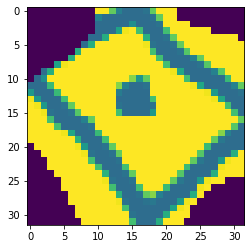

In [7]:
cimg=cv2.cvtColor(cv2.imread('cornertest4.png'), cv2.COLOR_BGR2GRAY)
plt.imshow(cimg)

In [35]:
logs=[]
ms=[i() for i in all_methods]
for m in ms:
    v1=m[1](images[0],log=logs)
    v2=m[1](cimg,log=logs)
    m[2](v1,v2,log=logs)

In [36]:
logs

[]

In [10]:
len(cimg.shape)

2

In [11]:
np.repeat(cimg[...,np.newaxis],3,axis=2)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [37]:
import timm

In [40]:
timm.list_models(pretrained=True)

['adv_inception_v3',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'cspdarknet53',
 'cspresnet50',
 'cspresnext50',
 'deit_base_distilled_patch16_224',
 'deit_base_distilled_patch16_384',
 'deit_base_patch16_224',
 'deit_base_patch16_384',
 'deit_small_distilled_patch16_224',
 'deit_small_patch16_224',
 'deit_tiny_distilled_patch16_224',
 'deit_tiny_patch16_224',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dm_nfnet_f0',
 'dm_nfnet_f1',
 'dm_nfnet_f2',
 'dm_nfnet_f3',
 'dm_nfnet_f4',
 'dm_nfnet_f5',
 'dm_nfnet_f6',
 'dpn68',
 'dpn

In [122]:
for t in timm_names:
    make_timm(t)